In [2]:
import numpy as np
from PIL import Image
import glob

In [3]:
# 전체 사진중 최대 해상도 찾기
dirNames = ['Aiden', 'Andrew','Cathy']           

widthRatio = []
heightRatio = []

for name in dirNames:    
    for file in sorted(glob.glob(f"../Data/Face/{name}/*.jpg")):        
        img = np.array(Image.open(file), dtype=np.int32)
        # print(img)
        # break
        widthRatio.append(img.shape[1])
        heightRatio.append(img.shape[0])


In [4]:
print("너비 최대 해상도 :", np.max(widthRatio))
print("높이 최대 해상도 :", np.max(heightRatio))

너비 최대 해상도 : 299
높이 최대 해상도 : 381


In [5]:
# > 해상도의 크기를 382 * 300
##### 전체 사진을 382 * 300의 고정 크기로 검은색을 배경으로 맞추기

for name in dirNames:
    fileCount = 0
    for file in sorted(glob.glob(f"../Data/Face/{name}/*.jpg")):
        img = Image.open(file)
        # img = img.convert('L') 컬러로 하니까 
        imgArray = np.array(img)

        imgDummy = np.zeros(382*300*3).reshape(382, 300, 3)    # (382*300*3)  컬러니까 *3 해준다
        rowNum = (382 - imgArray.shape[0]) / 2
        colNum = (300 - imgArray.shape[1]) / 2

        k = 0
        for i in range(int(rowNum), int(rowNum)+imgArray.shape[0]):
            l = 0
            for j in range(int(colNum), int(colNum)+imgArray.shape[1]):
                imgDummy[i,j] = imgArray[k,l]
                l+=1
            k+=1
        
        img2 = Image.fromarray(imgDummy.astype('uint8'))  # 어레이로 이미지 만들기
        img2.save(f"../Data/FaceColor/{name}/image_{fileCount:04d}.jpg", "JPEG")
        fileCount += 1

In [6]:
#### 사진들을 numpy배열로 Train Data 만들기
number_of_data = 18 * len(dirNames)
img_width_size = 300
img_height_size = 382
img_color = 3


train = np.zeros(
            number_of_data*img_width_size*img_height_size*img_color, dtype=np.int32
        # ).reshape(number_of_data,  img_width_size , img_height_size,  img_color) 
        ).reshape(number_of_data, img_height_size, img_width_size,  img_color) 

i = 0
for name in dirNames:
    for file in sorted(glob.glob(f"../Data/FaceColor/{name}/*.jpg")):
        img = np.array(Image.open(file), dtype=np.int32)
        train[i,:,:] = img
        i+=1

In [7]:
train.shape

(54, 382, 300, 3)

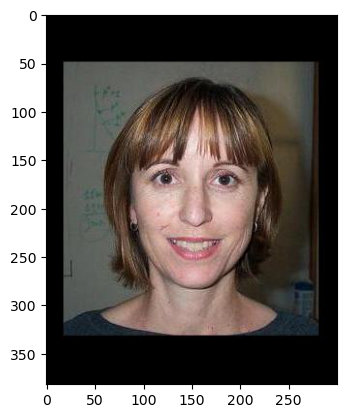

In [8]:
import matplotlib.pyplot as plt

# plt.imshow(train[40].reshape(400, 300), cmap='gray')
plt.imshow(train[40].reshape(382, 300, 3))
plt.show()

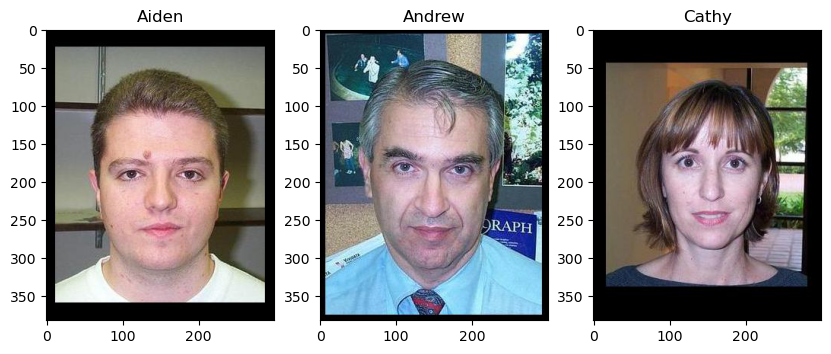

In [9]:
plt.figure(figsize=(10, 10))
orderNo = list(range(0, len(dirNames)*18, 18))

for i in range(1, len(dirNames)+1):
    plt.subplot(1, len(dirNames), i)
    # plt.imshow(train[orderNo[i-1]].reshape(382, 300, 3), cmap='gray')
    plt.imshow(train[orderNo[i-1]].reshape(382, 300, 3), cmap='gray' )
    plt.title(dirNames[i-1])

In [10]:
target = np.concatenate(
            [np.zeros(18), np.ones(18), np.full((18), 2)]
)
target

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2.])

In [11]:
# 정규화
train = train.reshape(-1, 382, 300, 3) / 255.0

In [12]:
# train과 test분리
from sklearn.model_selection import train_test_split

trainData, testData, trainTarget, testTarget = \
                        train_test_split(
                            train,
                            target,
                            test_size=0.2,
                            random_state=42
                        )

In [13]:
print(trainData.shape)
print(testData.shape)
print(trainTarget.shape)
print(testTarget.shape)

(43, 382, 300, 3)
(11, 382, 300, 3)
(43,)
(11,)


In [14]:
# CNN 만들기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf


model = Sequential()

model.add(Input( shape=(382, 300, 3) ))
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(2))
model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(2))

model.add(Flatten())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

mc = ModelCheckpoint('../Data/best_model0809_color.keras', monitor='val_loss', save_best_only=True)
es = EarlyStopping(patience=5, restore_best_weights=True)


history = model.fit(
    trainData, trainTarget,
    epochs=10,
    validation_data=(testData, testTarget),
    callbacks=[mc, es]
)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.2558 - loss: 5.0564 - val_accuracy: 0.4545 - val_loss: 5.6798
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 6s/step - accuracy: 0.3721 - loss: 8.7117 - val_accuracy: 0.5455 - val_loss: 2.4949
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 4s/step - accuracy: 0.7209 - loss: 2.0872 - val_accuracy: 0.5455 - val_loss: 2.2530
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.8605 - loss: 0.6922 - val_accuracy: 0.7273 - val_loss: 0.5395
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.9070 - loss: 0.1905 - val_accuracy: 1.0000 - val_loss: 0.0791
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 718ms/step - accuracy: 0.9535 - loss: 0.1336 - val_accuracy: 0.9091 - val_loss: 0.2486
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 714ms/step - accuracy: 1.0000 - loss: 0.0470 - val_accuracy: 0.9091 - val_loss: 0.1763
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 729ms/step - accuracy: 1.0000 - loss: 0.0575 - val_accuracy: 1.0000 - val_loss: 0.1086
Epoch 9

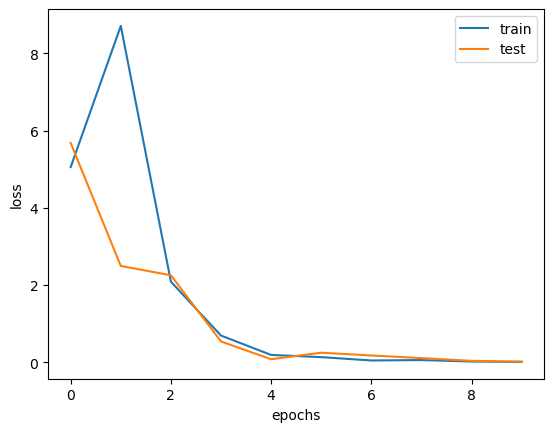

In [15]:
# 시각화 해보기
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.show()

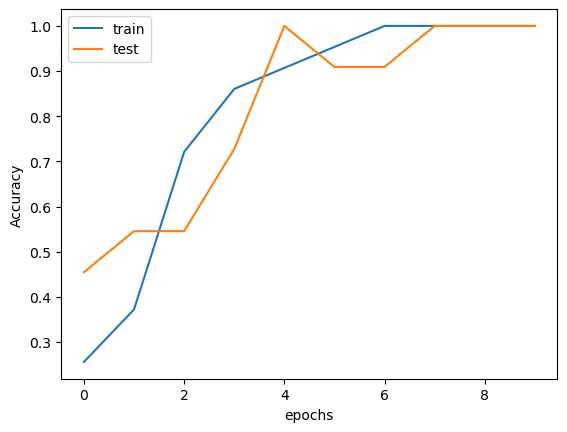

In [16]:
# 시각화 해보기
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])
plt.show()

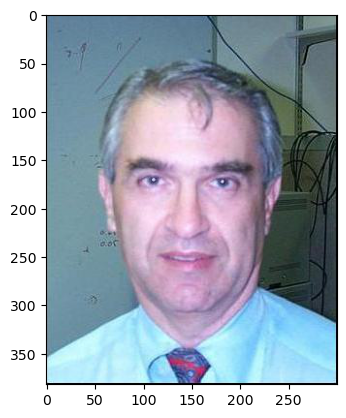

In [17]:
### 확인
plt.imshow(testData[0].reshape(382, 300,3))
plt.show()

In [18]:
model.predict(testData[0:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


array([[4.7123913e-07, 9.9999952e-01, 2.0772285e-08]], dtype=float32)

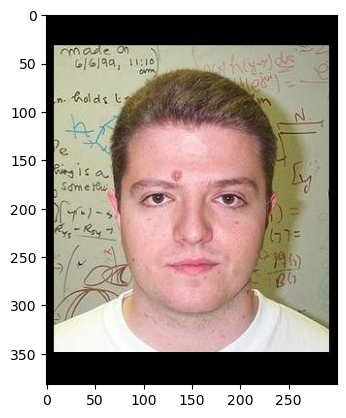

In [22]:
### 확인
plt.imshow(testData[10].reshape(382, 300,3))
plt.show()

In [20]:
model.predict(testData[10:11])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


array([[9.9997330e-01, 1.2396083e-05, 1.4293939e-05]], dtype=float32)

In [21]:
dirNames[np.argmax([9.9997807e-01, 9.3082940e-07, 2.0947389e-05])]

'Aiden'